In [1]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML; HTML(open("custom.html", "r").read())

# Chapter 2: Classification

As we have learned in the previous chapter *classification* is a machine learning problem belonging to a group of *supervised learning* problems. In classification the aim is to learn how to predict a class of a categorical label, based on set of already labelled training examples (hence, supervised). Such labels (categories) and corresponding classes can be:

- sick: yes / no,
- character: good / bad / dont't know,
- digit: 0 / ... / 9.

In this chapter we introduce the core concepts of classification.

## How to build a simple classifier?

Let's quickly look again at the beer example:

,alcohol_content,bitterness,darkness,fruitiness,is_yummy
count,225.000,225.000,225.000,225.000,225.000
mean,4.712,0.464,2.575,0.223,0.529
std,0.437,0.227,1.726,0.117,0.500
min,3.074,0.000,0.000,0.000,0.000
25%,4.429,0.281,1.198,0.136,0.000
50%,4.741,0.488,2.027,0.242,1.000
75%,5.005,0.631,4.044,0.312,1.000
max,5.955,1.080,7.221,0.535,1.000


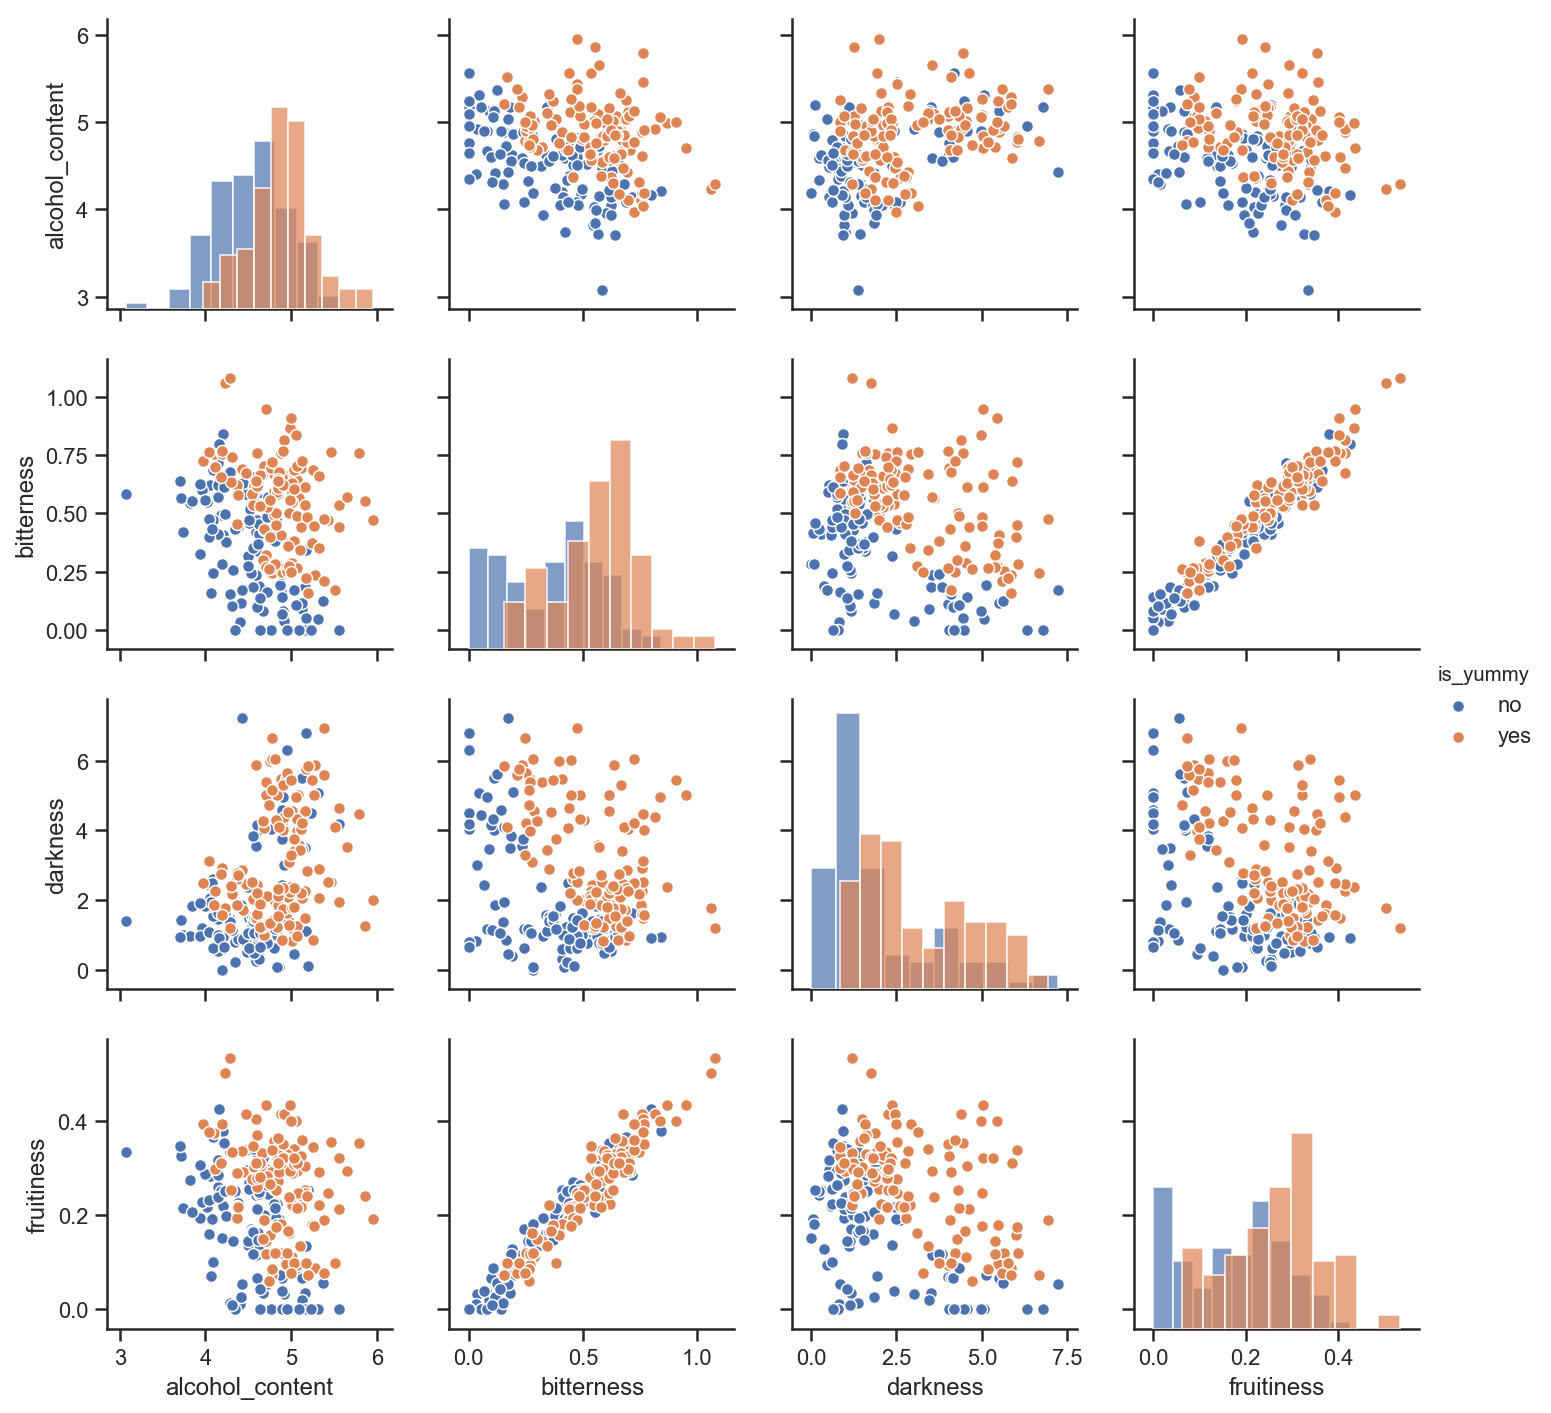

In [2]:
import pandas as pd
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="ticks")

beer_data = pd.read_csv("beers.csv")

for_plot = beer_data.copy()

# fixes seaborn labels issue
def translate_label(value):
    return "no" if value == 0 else "yes"

for_plot["is_yummy"] = for_plot["is_yummy"].apply(translate_label)

sns.pairplot(for_plot, hue="is_yummy", diag_kind="hist", diag_kws=dict(alpha=.7));
beer_data.describe()

We can assume that the person who rated these beers has preferences such as:
* "I don't like too low alcohol content",
* "I like more fruity beers", etc.

This means we could construct a score where high numbers relate to "favorable beer". One simple way to implement such a score is to use a weighted sum like:

     score = 1.1 * alcohol_content + 4 * bitterness + 1.5 * darkness + 1.8 * fruitiness

The actual weights here are guessed and serve as an example.

The size of the numbers reflects the numerical ranges of the features: alcohol content is in the range 3 to 5.9, where as bitterness is between 0 and 1.08:

In [3]:
scores =( 1.1 * beer_data["alcohol_content"] + 4 * beer_data["bitterness"] 
          + 1.5 * beer_data["darkness"] + 1.8 * beer_data["fruitiness"])
scores.shape

(225,)

Now we can plot the histogram of the scores by classes:

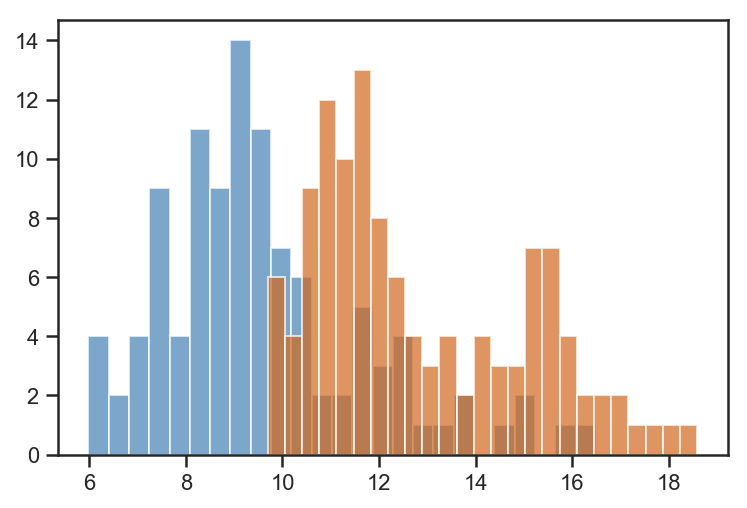

In [4]:
scores_bad = scores[beer_data["is_yummy"] == 0]
scores_good = scores[beer_data["is_yummy"] == 1]

plt.hist(scores_bad, bins=25, color="steelblue", alpha=.7) # alpha makes bars translucent
plt.hist(scores_good,  bins=25, color="chocolate", alpha=.7);

Consequence: a simple classifier could use these scores and use a threshold around 10.5 to assign a class label.

In [5]:
def classify(beer_feature):
    scores = (1.1 * beer_feature["alcohol_content"] + 4 * beer_feature["bitterness"] 
              + 1.5 * beer_feature["darkness"] + 1.8 * beer_feature["fruitiness"])
    if scores > 10.5:
        return "yummy"
    else:
        return "not yummy"

# check this for samples 5 .. 14:
for i in range(5, 15):
    tobe = translate_label(beer_data["is_yummy"][i])
    classified_as = classify(beer_data.iloc[i, :])
    print(i, 
          "is yummy?", "{:3s}".format(tobe),
          ".. classified as", classified_as)

5 is yummy? no  .. classified as not yummy
6 is yummy? yes .. classified as yummy
7 is yummy? yes .. classified as yummy
8 is yummy? no  .. classified as not yummy
9 is yummy? yes .. classified as yummy
10 is yummy? yes .. classified as yummy
11 is yummy? yes .. classified as yummy
12 is yummy? yes .. classified as not yummy
13 is yummy? no  .. classified as yummy
14 is yummy? yes .. classified as yummy


**This is how "linear" classifiers work. The magic is in computing the weights and the final threshold to guarantee good results.**

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
Although this seems to be a simplistic concept, linear classifiers can actually work very well, especially for problems with many features (high-dimensional problems).
</div>


## Exercise section 1

- Modify the weights in the beer classifiers and check if you can improve separation in the histogram.


- In `scikit-learn` the weights of a trained linear classifier are availble via the `coef_` attribute as a 2 dimensional `numpy` array. Extract the weights from the `LogisticRegression` classifier example from the last script and try them out in your weighted sum scoring function.

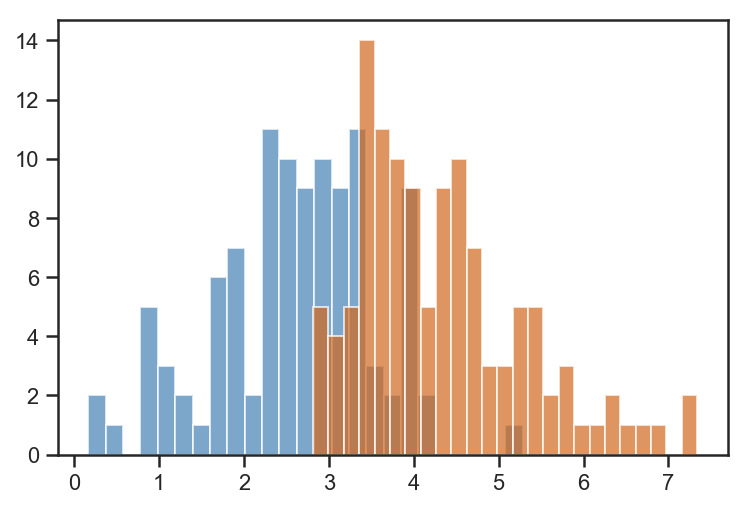

In [6]:
from sklearn.linear_model import LogisticRegression


classifier = LogisticRegression()
input_features = beer_data.iloc[:, :-1]
labels = beer_data.iloc[:, -1]
classifier.fit(input_features, labels)
w = classifier.coef_[0]

scores =( w[0] * beer_data["alcohol_content"] + w[1] * beer_data["bitterness"] 
          + w[2] * beer_data["darkness"] + w[3] * beer_data["fruitiness"])

scores_bad = scores[beer_data["is_yummy"] == 0]
scores_good = scores[beer_data["is_yummy"] == 1]

plt.hist(scores_bad, bins=25, color="steelblue", alpha=.7) # alpha makes bars translucent
plt.hist(scores_good,  bins=25, color="chocolate", alpha=.7);

## Geometrical interpretation of feature vectors

If you take the values of an input-feature vector you can imagine this as a point in a n-dimensional space.

E.g. if a data set consists of feature vectors of length 2, you can interpret the first feature value as a x-coordinate and the second value as a y-coordinate.

Classes then group points.

### Example

For sake of simplicity we restrict our beer data set to two features: `alcohol_content` and `bitterness`.

The following plot shows how these reduced feature vectors can be interpreted as point clouds. For every feature vector we color points in green or red to indicate the according classes:

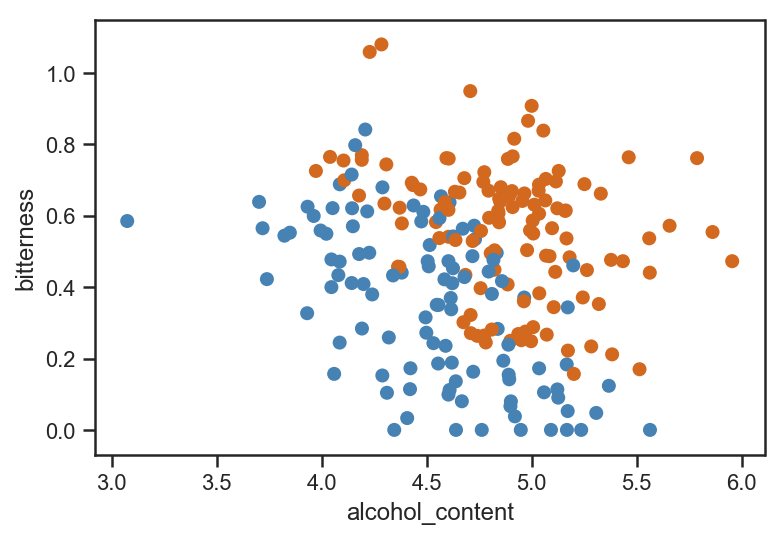

In [7]:
xv = beer_data["alcohol_content"]
yv = beer_data["bitterness"]

colors = [["steelblue", "chocolate"][i] for i in beer_data["is_yummy"]]

plt.scatter(xv, yv, color=colors, marker='o');
plt.xlabel("alcohol_content")
plt.ylabel("bitterness");


What do we see here ?

1. Both point clouds overlap, this tells us that the two features lack information for a 100% separation of classes. 
2. We could draw a line to separate most points of both clouds.
3. Later we could use this line to make a guess for classifying a new feature vector.

<div class="alert alert-block alert-warning">
<p><i class="fa fa-warning"></i>&nbsp;
Eventually, classification is about finding a procedure to separate point clouds in a n-dimesional space.
</p>
</div>

<img src="https://i.imgflip.com/303vuc.jpg" width=50%/>

Next we illustrate how more features can support classification. We add the `darkness` feature as third dimension.


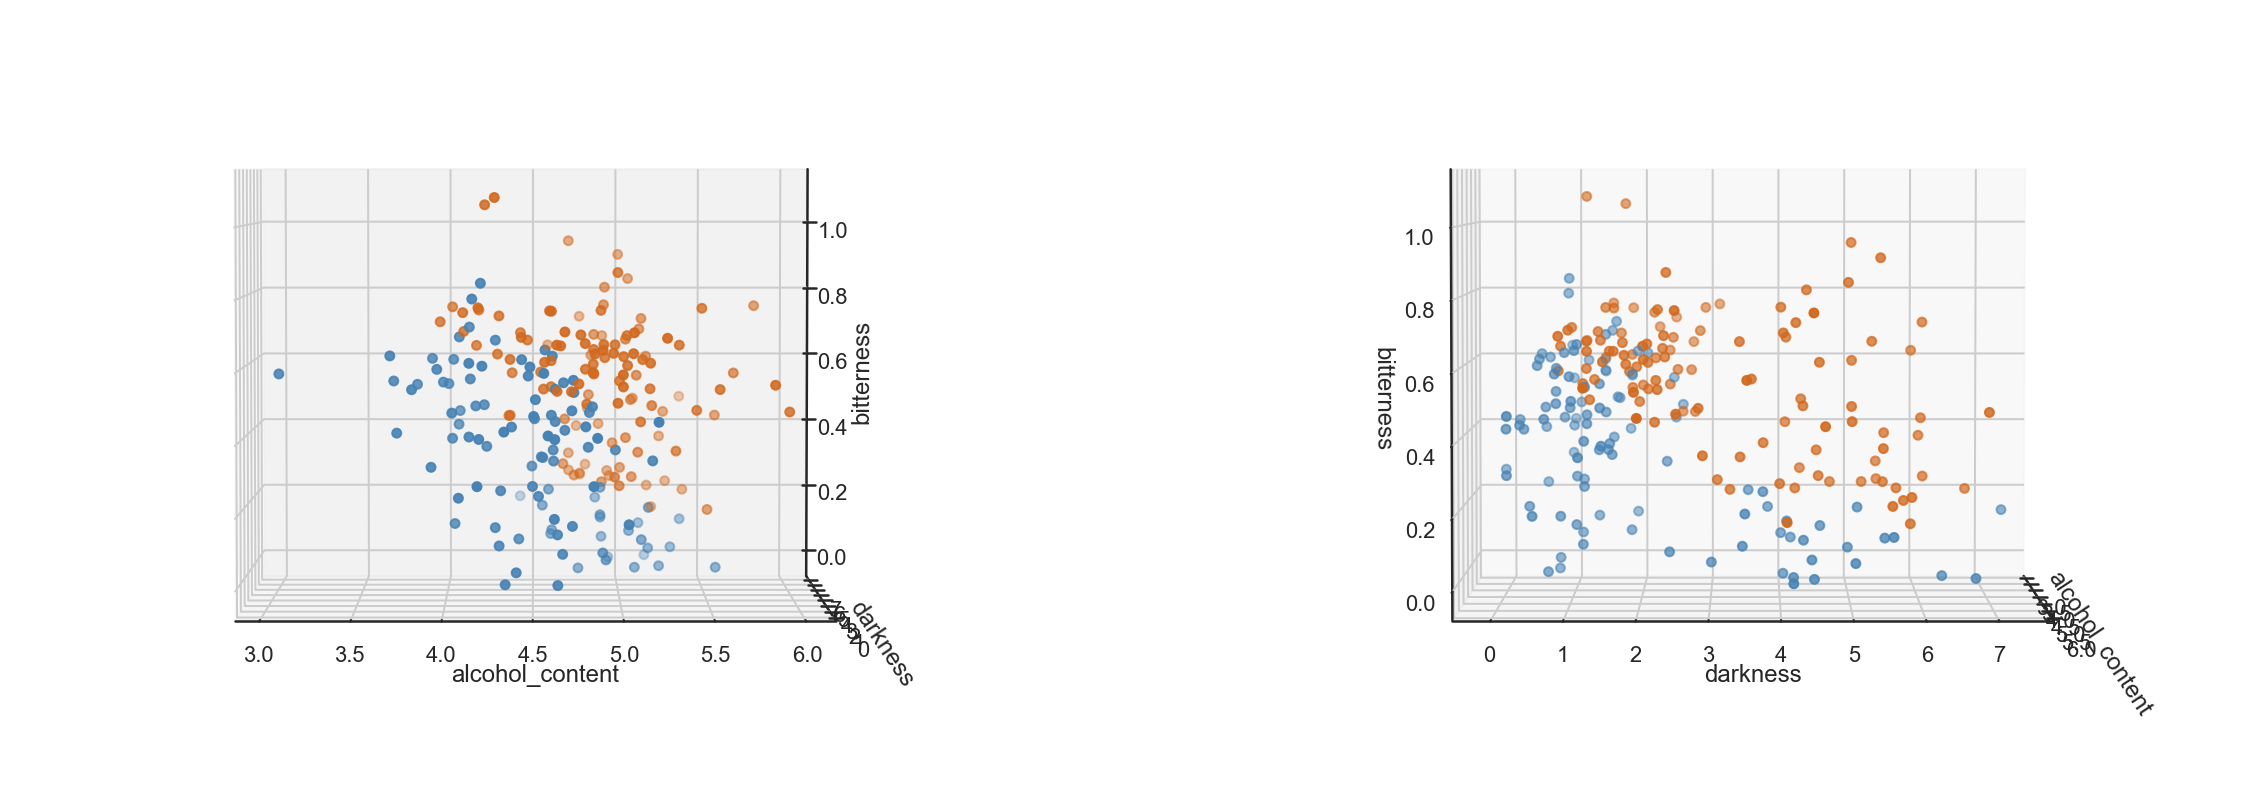

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 7))

xv = beer_data["alcohol_content"]
yv = beer_data["darkness"]
zv = beer_data["bitterness"]

colors = [["steelblue", "chocolate"][i] for i in beer_data["is_yummy"]]

def plot3d(ax):
    ax.scatter(xv, yv, zv, c=colors, marker='o') 
    
    ax.set_xlabel('alcohol_content')
    ax.set_ylabel('darkness')
    ax.set_zlabel('bitterness');

ax = fig.add_subplot(121, projection='3d')

plot3d(ax)
ax.view_init(3, 270)

ax = fig.add_subplot(122, projection='3d')
plot3d(ax)
ax.view_init(3, 0);

The first view is very similar to the scatter plot before as we don't see the effects of the third feature. 

The second view shows the same cube rotated by 90˚ horizontally. We see that the new dimension adds extra information which could improve separation by separating more points.

Geometrically, the 1D line, which could separat samples in the previous example that used 2D samples, would be now a 2D plane. It would still look like a line in the first view, but rotating it using the third dimensions could separate more points.


### Decision surfaces

The concept of decision surfaces is crucial in classification.

Lets start with an easy to visualize 2D features space.

#### Decision lines

For a score based on a weighted sum for two features `x` and `y` the equation


     weight_x * x + weight_y * y = threshold
     

defines a line in 2D space. Points fulfilling

     weight_x * x + weight_y * y < threshold
      
      
vs

     weight_x * x + weight_y * y > threshold
      

are located on opposite sides of this line. Such a classifier thus determines a line which separates the feature space in two parts according to the two classes.

Lets visualize this! 

We 

1. define a decision line (weights and threshold),
2. create random 2D samples,
3. compute scores for the samples,
4. split points according to their score compared to the threshold,
5. plot samples in different colors,
6. plot decision line.


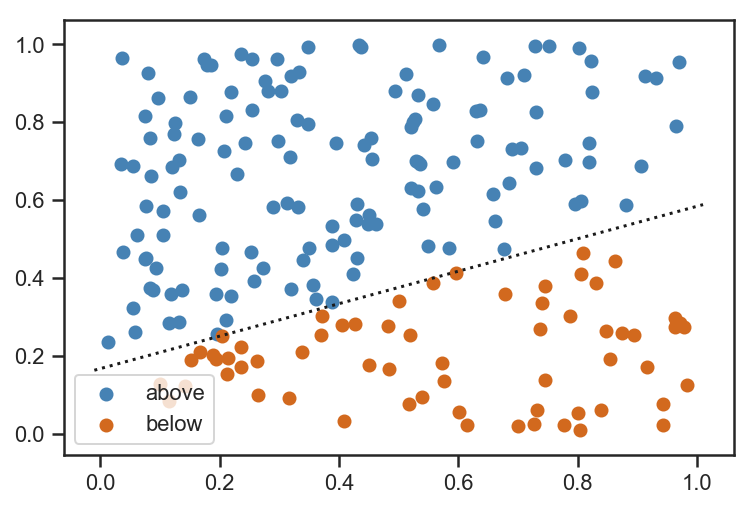

In [12]:
import numpy as np

# define a decision line
wx = -.5
wy = 1.2
weights = np.array((wx, wy))
threshold = 0.2

# create random 2D samples
points_2d = np.random.random((200, 2))

# compute scores for the samples
scores = points_2d  @ weights # (samples matrix) x (weights vector) = (scores vector)

# split points according to their score compared to the threshold 
above_points = points_2d[scores > threshold]
below_points = points_2d[scores < threshold]

# plot samples in different colors
plt.scatter(above_points[:, 0], above_points[:, 1], label="above",
            color="steelblue", marker="o")
plt.scatter(below_points[:, 0], below_points[:, 1], label="below",
            color="chocolate", marker="o")

# plot decision line
x = np.linspace(-.01, 1.01, 2)
y = threshold / weights[1] - weights[0] / weights[1] * x
plt.plot(x, y, color='k', linestyle=':')
plt.legend();

#### Decision (hyper)plane

For 3D samples a linear classifiers separates into classes by a 2D plane, and in general, for `n` dimensions we get `n-1` dimensional hyperplanes.

Let's visualize a decision plane the same way we did visualize the line.

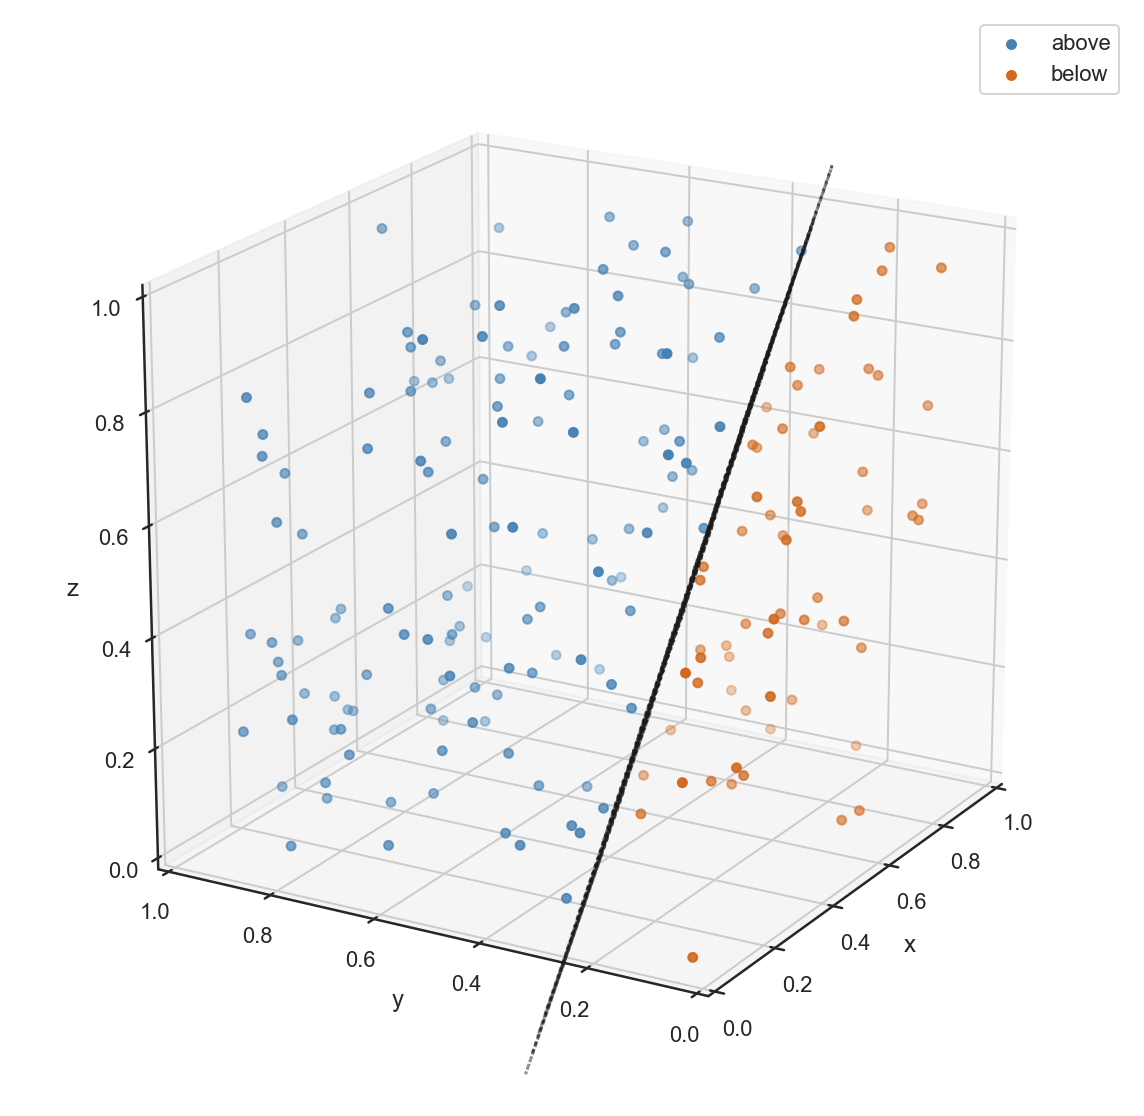

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# define a decision line
wx = -.5
wy = 1.2
wz = .4
weights = np.array((wx, wy, wz))
threshold = 0.3

# create random 3D samples
points_3d = np.random.random((200, 3))

# compute scores for the samples
scores = points_3d @ weights   # (samples matrix) x (weights vector) = (scores vector)

# split points according to their score compared to the threshold 
above_points = points_3d[scores > threshold]
below_points = points_3d[scores < threshold]

# plot samples in different colors
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

sc_above = ax.scatter(above_points[:, 0], above_points[:, 1], above_points[:, 2],
                      color="steelblue", marker="o")
sc_below = ax.scatter(below_points[:, 0], below_points[:, 1], below_points[:, 2],
                      color="chocolate", marker="o")
ax.legend([sc_above, sc_below], ['above', 'below'], numpoints=1)

# plot decision plane
x = np.linspace(-1, 2, 50)
y = np.linspace(-1, 2, 50)
xx, yy = np.meshgrid(x, y)
zz = (threshold - weights[0] * xx - weights[1] * yy) / weights[2]
zz_cut = np.copy(zz) # don't plot points outside of the [0,1] range
zz_cut[zz < 0.2] = np.nan
zz_cut[zz > .8] = np.nan
ax.plot_wireframe(xx, yy, zz_cut, color='k', linestyle=':', alpha=.5)

ax.view_init(20, 210);

### Example

In the initil beer example, features fulfilling

    1.1 * alcohol_content + 4 * bitterness + 1.5 * darkness + 1.8 * fruitiness == threshold
    
are located on a 3D hyperplane in a 4D features space.

Samples, which we classified as "not yummy", fullfilling:

    1.1 * alcohol_content + 4 * bitterness + 1.5 * darkness + 1.8 * fruitiness < threshold
    
and samples, which we classfied as "yummy class", fullfilling:

    1.1 * alcohol_content + 4 * bitterness + 1.5 * darkness + 1.8 * fruitiness > threshold
    
are located on different sides of this plane.

Again: **Here the classifier separates the 4D space into two parts, the separation boundary is a 3D hyperplane in this space.**

<div class="alert alert-block alert-info">

<h3><i class="fa fa-info-circle"></i>&nbsp;About 2D examples</h3>

<p>For the sake of simplicity and visualisation we continue with 2 dimensional examples.</p>

<p>It is clear that such examples only represent very small subset of realistic ML scenarios. But most concepts can be illustrated in 2D or 3D without loss of generality.</p>

<p>The examples also might look artificial, this is because they highlight specific aspects or problems. At the end, general classifiers should work on all kind of problems.</p>
</div>



## Non-linear decision surfaces

The next example data set can not be classified by a straight line, the decision line is curved:


In [14]:
df = pd.read_csv("2d_points.csv")
df.head(3)

,x,y,label
0,-0.502,1.803,False
1,0.928,0.395,True
2,-1.376,-1.376,False


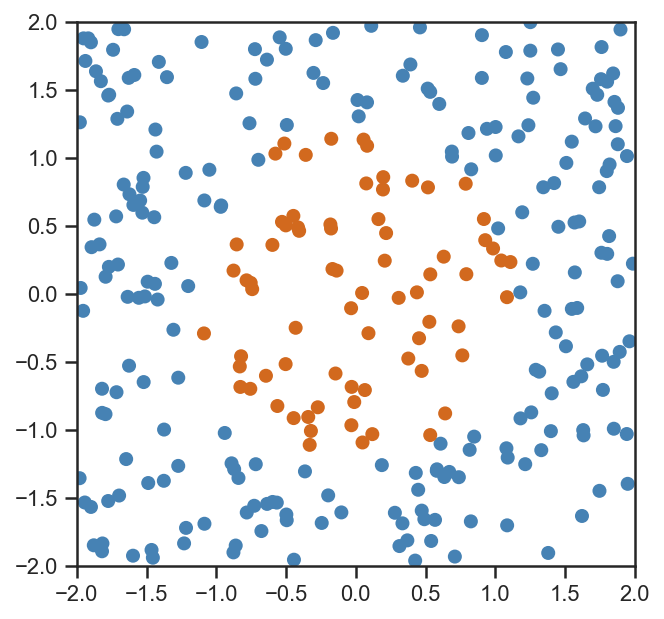

In [15]:
xv = df["x"]
yv = df["y"]

colors = [["steelblue", "chocolate"][i] for i in df["label"]]
plt.figure(figsize=(5, 5))
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.scatter(xv, yv, color=colors, marker="o");

In this case a suitable decision surface is a (closed) curve - it looks like a circle. A hand-crafted classifier could classify new points based on their distance to the center.

It should be clear that a **linear classifier is not suitable for this problem**!

## Feature engineering

To improve ML performance we can try to create new feature by transformation of existing features. This process is called **feature engineering**.

This is actually the opposite of "garbage in / garbage out".

<img src="https://i.imgflip.com/303whl.jpg" width=50% title="made at imgflip.com"/>

The general idea is to include / extract usefull information based on domain knowledge. 

E.g. to classify spam emails you can count the number of words written in capital letters only or group countries and add the group number.

### An example for feature engineering

In the previous example we see that the distance of the origin of a point could be used to implement a classifier.

Computing the distance of a point to the origin (0, 0) using the euclidian formula includes terms $x^2$ and $y^2$. 

Let us create a scatter plot for this transformation:

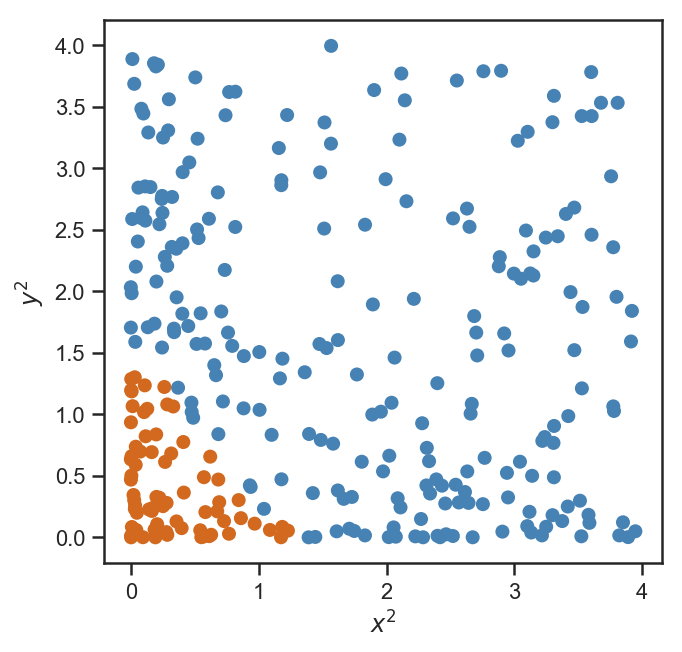

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(xv ** 2, yv ** 2, color=colors, marker='o');
plt.xlabel("$x^2$")
plt.ylabel("$y^2$");

As you can see both sets can be separated by a line now!

### Another example for feature engineering

The so called "xor-problem" is a typical benchmark problem for machine learning. The following example illustrates this problem:

In [17]:
xor = pd.read_csv("xor.csv")
xor.head()

,x,y,label
0,-1.540,0.951,False
1,0.436,-1.768,False
2,-1.466,1.392,False
3,-1.038,-0.954,True
4,-0.691,-0.220,True


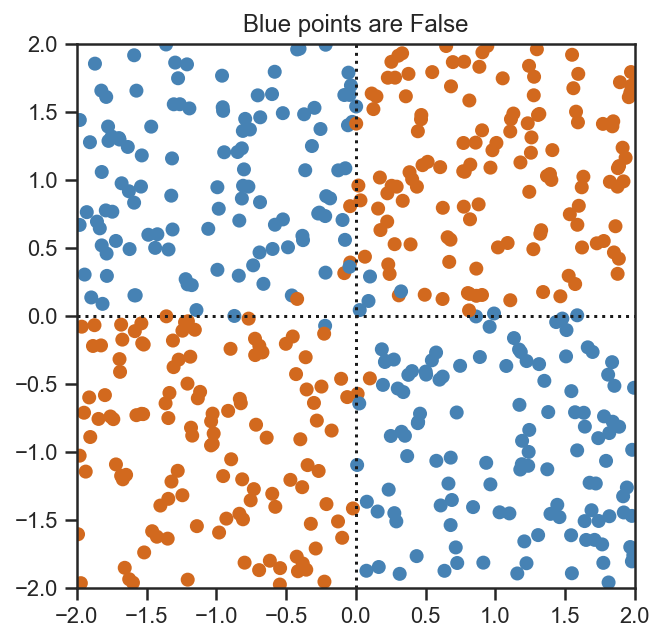

In [18]:
xv = xor["x"]
yv = xor["y"]

colors = [["steelblue", "chocolate"][i] for i in xor["label"]]
plt.figure(figsize=(5, 5))
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([0, 0], [-2, 2], "k:")
plt.plot([-2, 2], [0, 0], "k:")
plt.title("Blue points are False")
plt.scatter(xv, yv, color=colors, marker="o");

Again, this example data set can not be separated by a line. But we see that points where the sign of x and y are the same appear to form one class, and point with different signs for x and y belong to the other class.

Let's engineer a new numerical feature corresponding to a descriptive feature "x and y have the same sign". How? 

Here we can use the fact that the product of two numbers is postive if and only if both numbers have the same sign.

So lets plot a histogram over `x * y`:

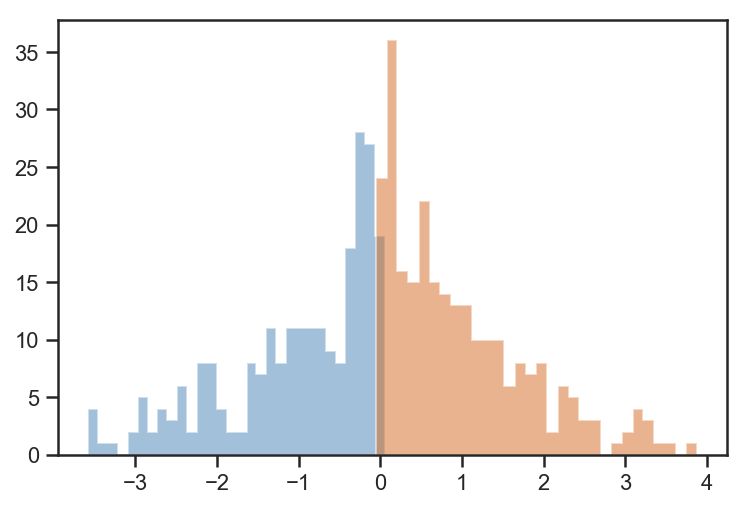

In [19]:
products = xor["x"] * xor["y"]

features_class_false = products[~xor["label"]]
features_class_true = products[xor["label"]]

plt.hist(features_class_false,  bins=30, color="steelblue", alpha=.5, histtype="stepfilled")
plt.hist(features_class_true,  bins=30, color="chocolate", alpha=.5, histtype="stepfilled");

Having such feature a simple classifier could just introduce a threshold of 0 to distinguish both classes.

### Feature engineering HOWTO

Manual feature engineering is difficult. It requires understanding of data to extract useful features.

However, feature engineering can boost the performance of a classifier significantly.

Examples:

- early classifiers to detect nudity in images used color histograms of full image and image patches (plus more features) to create suitable features.


- spam classifieries depend on choice of dictionary, or counting words only in capital cases, or counting words with special characters (like "pill$")


- to distinguish background noise from speach audio samples, the frequency distribution might help, as well as standard deviation, or a histogram, of loudness/energy of a sample.


- to classify DNA sequences, n-gram histograms (n>=1) can be benefitial.


- geopolitical data can be enhanced from a feature "state" by extra features of "political system" and/or "gross national product (GNP)".


- sales data can be enhanced from a date feature by an extra feature "is weekday".

Most cases have higher dimensions than 2 or 3 and visual inspection can be difficult. Thus, engineering features as we did in the 2D examples becomes tricky.

<div class="alert alert-block alert-warning"><p><i class="fa fa-warning"></i>&nbsp;
General recommendations for feature extraction:
<ul>
<li>use descriptive statistics (mean, standard deviations, higher order statistics), as well as histograms if applicable;</li>
<li>polynomial features (e.g. extend <code>x, y</code> to <code>x, y, x * y, x ** 2, y ** 2</code>) (see below);</li>
    <li>image classification: dig into computer vision to learn about image descriptors;</li>
<li>audio classification: learn about FFT, wavelets, filter banks, power spectrum, ...;</li>
<li>try to incorporate external data.</li>
</ul>
</p></div>

<div class="alert alert-block alert-info"><p><i class="fa fa-info-circle"></i>&nbsp;
Adding too many features (especially redundant features) can introduce other problems, such as, for instance, <strong>overfitting</strong> (we'll learn later about that). There are methods for selection of a subset of "good-enough" features (cf. <a href="https://scikit-learn.org/stable/modules/feature_selection.html"><code>scikit-learn</code> feature selection module</a>).
</p></div>

### Engineer polynomial features using `scikit-learn`

*Polynomial features* are a way to (semi-)automatically engineere new non-linear features. These are all polynomial combinations of the features (up to given degree).

In <code>scikit-learn</code> polynomial feature engineering is part of the `sklearn.preprocessing` module containing utilities for features preprocessing.

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;<strong><code>scikit-learn</code> API</strong>

In scikit-learn</code> preprocessing utilites have:
<ul>
    <li>a <strong><code>transform()</code></strong> method to appropriately transform data
        
</ul>

and, if applicable<ul>
    <li>a <strong><code>fit()</code></strong> and <strong><code>fit_transform()</code></strong> methods to learn the preprocessing from data or fit and transform in one step.</li>
</ul>
</div>

For instance, the "sign" feature `x * y` in the XOR dataset in the previous example is a polynomial feature of rank 2 (1+1). Let's see how to generate it among with other polynomial features up to rank 2 using `scikit-lern`:

In [20]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# using first 10 samples from XOR data
df = pd.read_csv("xor.csv")
features = df.iloc[:, :-1]
features.head()

,x,y
0,-1.540,0.951
1,0.436,-1.768
2,-1.466,1.392
3,-1.038,-0.954
4,-0.691,-0.220


In [23]:
preproc = PolynomialFeatures(degree=2, include_bias=False)
data = preproc.fit_transform(features)
pd.DataFrame(data).head()

,0,1,2,3,4
0,-1.540,0.951,2.371,-1.464,0.904
1,0.436,-1.768,0.190,-0.771,3.127
2,-1.466,1.392,2.150,-2.041,1.937
3,-1.038,-0.954,1.077,0.989,0.909
4,-0.691,-0.220,0.478,0.152,0.048


In this case 
- columns `0` and `1` are $x$ and $y$ from the original data set.
- column `2` is $x^2$
- column `3` is $x y$
- column `4` is $y^2$.

Setting `include_bias=False` omits the only degree 0 polynomial, which is a constant column of `1` value. For a complete description see [docs for `sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

## Exercise section 2

The following functions plot a 2D dataset points and a decision surface of classifier trained beforehand on that dataset.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_points(features_2d, labels, plt=plt, marker='o'):
    colors = [["steelblue", "chocolate"][i] for i in labels]
    plt.scatter(features_2d[:, 0], features_2d[:, 1], color=colors, marker=marker);

    
def train_and_plot_decision_surface(
    name, classifier, features_2d, labels, preproc=None, plt=plt, marker='o', N=200
):

    features_2d = np.array(features_2d)
    
    xmin, ymin = features_2d.min(axis=0)
    xmax, ymax = features_2d.max(axis=0)

    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

    if preproc is not None:
        points_for_classifier = preproc.fit_transform(points)
        features_2d = preproc.fit_transform(features_2d)
    else:
        points_for_classifier = points

    classifier.fit(features_2d, labels)
    predicted = classifier.predict(features_2d)

    if preproc is not None:
        name += " (w/ preprocessing)"
    print(name + ":\t", sum(predicted == labels), "/", len(labels), "correct")

    classes = np.array(classifier.predict(points_for_classifier), dtype=bool)
    plt.scatter(
        points[~classes][:, 0],
        points[~classes][:, 1],
        color="steelblue",
        marker=marker,
        s=1,
        alpha=0.05,
    )
    plt.scatter(
        points[classes][:, 0],
        points[classes][:, 1],
        color="chocolate",
        marker=marker,
        s=1,
        alpha=0.05,
    )

    plot_points(features_2d, labels)
    plt.title(name)

Let's use them to plot a decision surface of a logistic regression classifier trained on a XOR dataset:

Logistic regression:	 304 / 500 correct


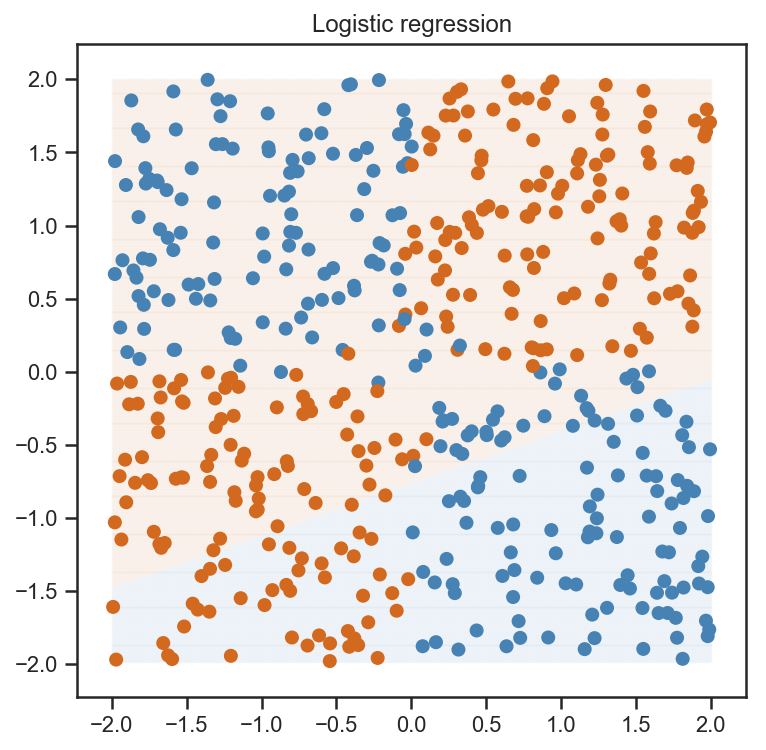

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("xor.csv")
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

clf = LogisticRegression()

plt.figure(figsize=(6, 6))

# preproc = PolynomialFeatures(2, include_bias=False)

train_and_plot_decision_surface("Logistic regression", clf, features, labels, preproc=None)

### a) Logistic regression with polynomial features

Train and plot decision surface for logistic regression classifier of XOR dataset with polynomial features engineered. What's the result and why?

Logistic regression (w/ preprocessing):	 486 / 500 correct


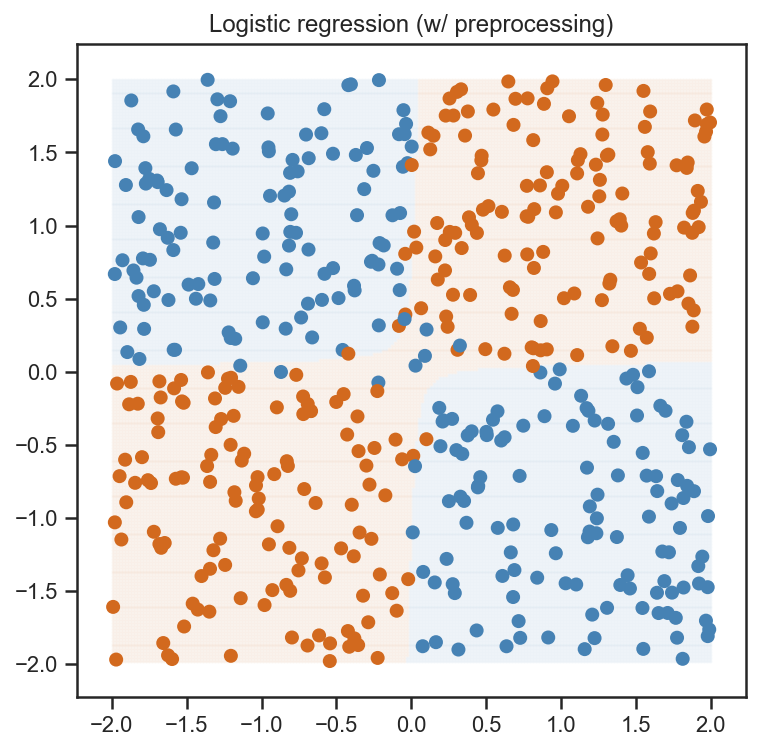

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("xor.csv")
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

clf = LogisticRegression()

plt.figure(figsize=(6, 6))

preproc = PolynomialFeatures(2, include_bias=False)
train_and_plot_decision_surface("Logistic regression", clf, features, labels, preproc=preproc)

### b) Comparison of decision surfaces for different classifiers and datasets

Compare decision surfaces for different classifiers listed below for both `"xor.csv"` and `"2d_points.csv"` (circle) datasets. For which classifiers does it help to add polynomial features? How many degrees suffice?

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# ....

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

def try_dataset(dataset, preproc):
    
    df = pd.read_csv(dataset)
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]
    
    plt.figure(figsize=(11, 28))
    
    clf = LogisticRegression()
 
    plt.subplot(5, 2, 1)
    train_and_plot_decision_surface("LogisticRegression", clf, features, labels, preproc=None, N=300)
    
    plt.subplot(5, 2, 2)
    train_and_plot_decision_surface("LogisticRegression", clf, features, labels, preproc=preproc, N=300)

    clf = LinearSVC()

    plt.subplot(5, 2, 3)
    train_and_plot_decision_surface("LinearSVC", clf, features, labels, preproc=None, N=300)
    
    plt.subplot(5, 2, 4)
    train_and_plot_decision_surface("LinearSVC", clf, features, labels, preproc=preproc, N=300)
    
    
    clf = SVC()
    plt.subplot(5, 2, 5)
    train_and_plot_decision_surface("SVC", clf, features, labels, preproc=None, N=300)
    plt.subplot(5, 2, 6)
    train_and_plot_decision_surface("SVC", clf, features, labels, preproc=preproc, N=300)

    
    clf = DecisionTreeClassifier()
    plt.subplot(5, 2, 7)
    train_and_plot_decision_surface("DecisionTreeClassifier", clf, features, labels, preproc=None, N=300)
    plt.subplot(5, 2, 8)
    train_and_plot_decision_surface("DecisionTreeClassifier", clf, features, labels, preproc=preproc, N=300)

    clf = KNeighborsClassifier()
    plt.subplot(5, 2, 9)
    train_and_plot_decision_surface("KNeighborsClassifier", clf, features, labels, preproc=None, N=300)
    
    plt.subplot(5, 2, 10)
    train_and_plot_decision_surface("KNeighborsClassifier", clf, features, labels, preproc=preproc, N=300)


try_dataset("xor.csv", PolynomialFeatures(2, include_bias=False))


LogisticRegression:	 304 / 500 correct
LogisticRegression (w/ preprocessing):	 486 / 500 correct
LinearSVC:	 304 / 500 correct
LinearSVC (w/ preprocessing):	 487 / 500 correct
SVC:	 487 / 500 correct
SVC (w/ preprocessing):	 484 / 500 correct
DecisionTreeClassifier:	 500 / 500 correct
DecisionTreeClassifier (w/ preprocessing):	 500 / 500 correct
KNeighborsClassifier:	 489 / 500 correct
KNeighborsClassifier (w/ preprocessing):	 483 / 500 correct


In [ ]:
try_dataset("2d_points.csv", PolynomialFeatures(2, include_bias=False))

## But.. what if there are more than two classes?


Previous and the following examples in this script consider two class problems.
Before we dig deeper into classification, let's say a few words on how to handle more than two classes.


<div class="alert alert-block alert-warning"><p><i class="fa fa-warning"></i>&nbsp;
    The general idea for <code>n > 2</code> classes is to build multiple 2-class classifiers and determine a winning class by applying all of them:
<ul>
    <li>in the <strong>one-vs-all</strong> approach build <code>n</code> classifiers for "label n vs. the rest";</li>
    <br/>
    
  <li>in the <strong>one-vs-one</strong> approach builds  classifiers for `label i vs label j` (in total <code>n x (n - 1) / 2</code> classifiers).</li>
</ul>
</p></div>

For new incoming data then all classifiers (`n` or `n x (n -1) / 2`) are applied and the overall winning class gives the final result.

For instance, to classify images of digits:

- we could build 10 classifiers `is it 0 or other digit`, `is it 1 or other digit`, etc.
  
  A new image then would hopefully yield `True` for exactly one of the classifier, in other situations the result is unclear.
   
   
- we could build 45 classifiers `is it 0 or 1`, `is it 0 or 2`, etc.

  For a new image we could choose the final outcome based on which class "wins" most often.


<div class="alert alert-block alert-info"><p><i class="fa fa-info-circle"></i>&nbsp;
    In <code>scikit-learn</code> many classifiers support multi-class problems out of the box and also offer functionalities to implement <strong>one-vs-all</strong> or <strong>one-vs-one</strong> in some cases (cf. <a href="https://scikit-learn.org/stable/modules/multiclass.html"><code>scikit-learn</code> multiclass and multilabel algorithms</a>).
</p></div>